In [2]:
!pip uninstall -y numpy

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2


In [3]:
!pip install --no-cache-dir numpy==1.26.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 150.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 180.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.3 which is incompatible.


In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
import numpy
numpy.__version__



'1.26.3'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
save_path_videos = '/content/drive/MyDrive/paths/dataset_Videos.npy'
save_path_labels = '/content/drive/MyDrive/paths/dataset_labels.npy'

In [4]:
import numpy as np

videos = np.load(save_path_videos)
labels = np.load(save_path_labels)

In [5]:
# Print the shape of the videos and labels arrays
print("Videos shape:", videos.shape) # output should be (no of videos, 50, 80, 112, 3)
print("Labels shape:", labels.shape)

Videos shape: (4050, 22, 80, 112, 1)
Labels shape: (4050,)


In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode the labels into numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# One-hot encode the labels
labels_onehot = to_categorical(labels_encoded)

# Display the mapping
print("✅ Label encoding mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i} → {label}")

print("✅ Labels encoded and one-hot encoded.")


✅ Label encoding mapping:
0 → a
1 → bye
2 → can
3 → cat
4 → demo
5 → dog
6 → hello
7 → here
8 → is
9 → lips
10 → my
11 → read
12 → you
✅ Labels encoded and one-hot encoded.


In [7]:
label_dict = {0:"a", 1: "bye", 2:"can", 3:"cat", 4:"demo", 5:"dog", 6: "hello", 7:"here", 8:"is", 9:"lips", 10:"my", 11:"read", 12:"you"}

In [8]:
from sklearn.model_selection import train_test_split

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    videos, labels_onehot, test_size=0.2, random_state=42, stratify=labels_encoded
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")


Training set: (3240, 22, 80, 112, 1), (3240, 13)
Validation set: (810, 22, 80, 112, 1), (810, 13)


In [9]:
import gc
gc.collect()
!cat /proc/meminfo | grep Mem


MemTotal:       13289424 kB
MemFree:          150960 kB
MemAvailable:    5178300 kB


In [10]:
del videos, labels, labels_encoded
gc.collect()

0

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import numpy as np
from tensorflow.keras.optimizers import Adam


def create_multiscale_temporal_cnn(input_shape=(22, 80, 112, 1), num_classes=13):
    """
    Multi-Scale Temporal CNN with different temporal kernel sizes

    Args:
        input_shape: (sequence_length, height, width, channels)
        num_classes: Number of output classes
    """
    inputs = layers.Input(shape=input_shape)

    # Shared CNN backbone for spatial feature extraction
    def create_spatial_branch():
        branch = keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),

            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu')
        ])
        return branch

    # Extract spatial features from each frame
    spatial_branch = create_spatial_branch()
    x = layers.TimeDistributed(spatial_branch)(inputs)

    # Multi-scale temporal branches
    # Branch 1: Short-term patterns (kernel size 3)
    branch1 = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.Conv1D(64, 3, padding='same', activation='relu')(branch1)

    # Branch 2: Medium-term patterns (kernel size 5)
    branch2 = layers.Conv1D(64, 5, padding='same', activation='relu')(x)
    branch2 = layers.BatchNormalization()(branch2)
    branch2 = layers.Conv1D(64, 5, padding='same', activation='relu')(branch2)

    # Branch 3: Long-term patterns (kernel size 7)
    branch3 = layers.Conv1D(64, 7, padding='same', activation='relu')(x)
    branch3 = layers.BatchNormalization()(branch3)
    branch3 = layers.Conv1D(64, 7, padding='same', activation='relu')(branch3)

    # Branch 4: Very long-term patterns (kernel size 11)
    branch4 = layers.Conv1D(64, 11, padding='same', activation='relu')(x)
    branch4 = layers.BatchNormalization()(branch4)
    branch4 = layers.Conv1D(64, 11, padding='same', activation='relu')(branch4)

    # Concatenate all branches
    merged = layers.Concatenate(axis=-1)([branch1, branch2, branch3, branch4])

    # Additional temporal processing
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(merged)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Global temporal pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Classification head
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='MultiScale_Temporal_CNN')
    return model

# Example usage
print("=== Multi-Scale Temporal CNN ===")
ms_cnn_model = create_multiscale_temporal_cnn(input_shape=(22, 80, 112, 1), num_classes=13)
ms_cnn_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
ms_cnn_model.summary()
print()

=== Multi-Scale Temporal CNN ===


Model: "MultiScale_Temporal_CNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 22, 80,    │          0 │ -                 │
│ (InputLayer)        │ 112, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 22, 128)   │     27,520 │ input_layer[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 22, 64)    │     24,640 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 22, 64)    │     41,024 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 22, 64)    │     57,408 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 22, 64)    │     90,176 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 64)    │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 64)    │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 64)    │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 22, 64)    │     12,352 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 22, 64)    │     20,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 22, 64)    │     28,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 22, 64)    │     45,120 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 22, 256)   │          0 │ conv1d_1[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 22, 128)   │     98,432 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 128)   │        512 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 22, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dropout[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 483,853 (1.85 MB)

 Trainable params: 482,893 (1.84 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

history = ms_cnn_model.fit(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=80,
             batch_size=8,
             callbacks=callbacks)

Epoch 1/80
405/405 ━━━━━━━━━━━━━━━━━━━━ 57s 63ms/step - accuracy: 0.0759 - loss: 2.7262 - val_accuracy: 0.0840 - val_loss: 2.5950 - learning_rate: 1.0000e-04
Epoch 2/80
405/405 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.0767 - loss: 2.6453 - val_accuracy: 0.0691 - val_loss: 2.6178 - learning_rate: 1.0000e-04
Epoch 3/80
405/405 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.0867 - loss: 2.6248 - val_accuracy: 0.1111 - val_loss: 2.5927 - learning_rate: 1.0000e-04
Epoch 4/80
405/405 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.0814 - loss: 2.6239 - val_accuracy: 0.0914 - val_loss: 2.6179 - learning_rate: 1.0000e-04
Epoch 5/80
405/405 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.1159 - loss: 2.5907 - val_accuracy: 0.0778 - val_loss: 2.5931 - learning_rate: 1.0000e-04
Epoch 6/80
405/405 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.1167 - loss: 2.5717 - val_accuracy: 0.1062 - val_loss: 2.5306 - learning_rate: 1.0000e-04
Epoch 7/80
405/405 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/ste

In [13]:
def evaluate_model(model, name="Model"):
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"{name} - Validation Accuracy: {acc:.4f}, Loss: {loss:.4f}")

evaluate_model(ms_cnn_model, "ms_cnn_model")



ms_cnn_model - Validation Accuracy: 0.6395, Loss: 1.0007


In [14]:
y_pred_prob = ms_cnn_model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step


In [15]:
from prettytable import PrettyTable
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

# Convert y_pred to one-hot encoded format to match y_val
y_pred_onehot = to_categorical(y_pred, num_classes=y_val.shape[1])

# Generate classification report
report = classification_report(y_val, y_pred_onehot, output_dict=True)

table = PrettyTable()
table.field_names = ["Class", "Precision", "Recall", "F1-Score", "Support"]
for label, metrics in report.items():
    if label.isdigit():
        precision = round(metrics['precision'], 2)
        recall = round(metrics['recall'], 2)
        f1_score = round(metrics['f1-score'], 2)
        support = metrics['support']
        table.add_row([label_dict[int(label)], precision, recall, f1_score, support])

print(table)

+-------+-----------+--------+----------+---------+
| Class | Precision | Recall | F1-Score | Support |
+-------+-----------+--------+----------+---------+
|   a   |    0.58   |  0.52  |   0.55   |   64.0  |
|  bye  |    0.34   |  0.34  |   0.34   |   62.0  |
|  can  |    0.51   |  0.61  |   0.55   |   61.0  |
|  cat  |    0.31   |  0.88  |   0.46   |   59.0  |
|  demo |    0.98   |  0.89  |   0.93   |   62.0  |
|  dog  |    0.78   |  0.88  |   0.83   |   60.0  |
| hello |    0.9    |  0.81  |   0.85   |   57.0  |
|  here |    0.72   |  0.76  |   0.74   |   66.0  |
|   is  |    0.62   |  0.32  |   0.42   |   65.0  |
|  lips |    0.8    |  0.73  |   0.76   |   64.0  |
|   my  |    0.73   |  0.12  |   0.21   |   64.0  |
|  read |    0.87   |  0.63  |   0.73   |   65.0  |
|  you  |    0.96   |  0.89  |   0.92   |   61.0  |
+-------+-----------+--------+----------+---------+


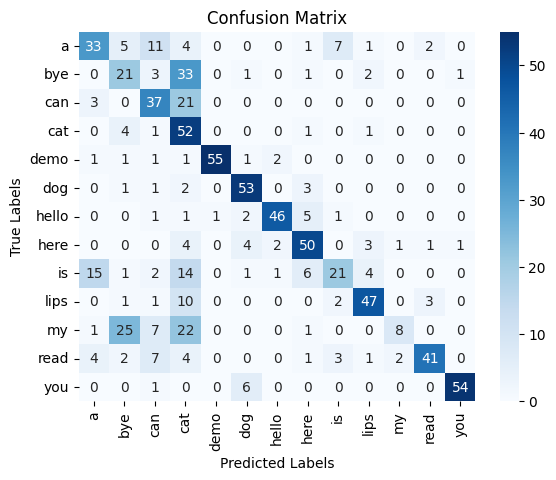

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# Convert y_val to multiclass format
y_val_multiclass = np.argmax(y_val, axis=1)  # Convert one-hot to class indices

# Now generate the confusion matrix
conf_matrix = sklearn.metrics.confusion_matrix(y_val_multiclass, y_pred)

# Define the list of label strings in the order of their integer values
label_strings = [label_dict[i] for i in range(len(label_dict))]

# Generate the heatmap confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=label_strings, yticklabels=label_strings)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

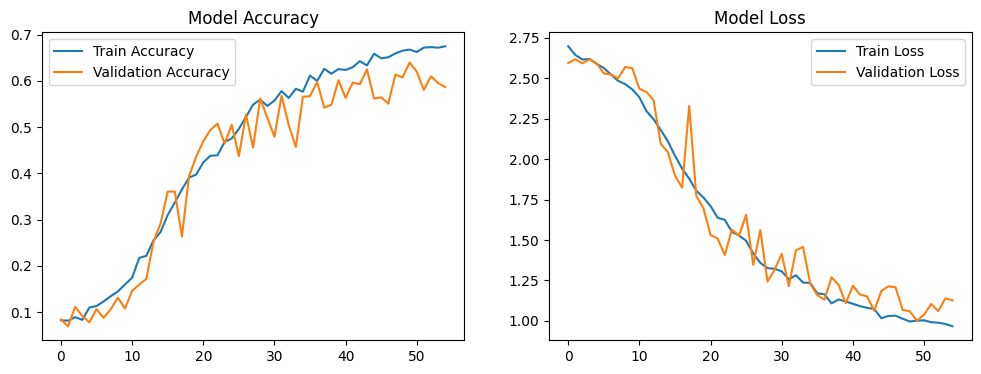

In [17]:
import matplotlib.pyplot as plt
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Model Loss')
    plt.show()

plot_training_history(history)


In [18]:
# Save the trained model
ms_cnn_model.save("/content/drive/MyDrive/models/ms_cnn_model.h5")
print("✅ Model saved.")


✅ Model saved.
